<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/GasCompressorTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Simulation of a Gas Compression Train
#@markdown A compressor is a mechanical device that increases the pressure of a gas by reducing its volume.
#@markdown Compressors are similar to pumps: both increase the pressure on a fluid and both can transport the fluid through a pipe. As gases are compressible, the compressor also reduces the volume of a gas. Liquids are relatively incompressible; while some can be compressed, the main action of a pump is to pressurize and transport liquids.
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Litterature

https://petrowiki.org/Compressors

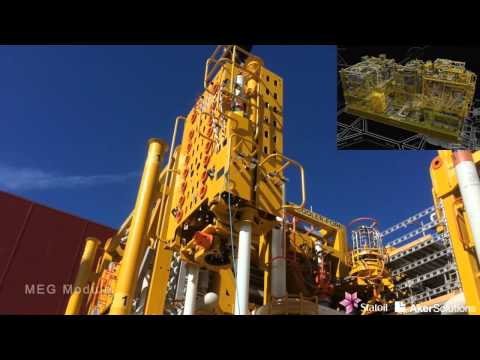

In [2]:
#@title  Åsgard Subsea Gas Compression
#@markdown The installation of the modules that collectively constitute Åsgard subsea gas compression has commenced in the Åsgard field.​
#@markdown Innovative technology at a depth of 300 metres will create more than 300 million extra barrels BOE from the Åsgard field.
from IPython.display import YouTubeVideo
YouTubeVideo('WXaTF_ajADE', width=600, height=400)

# Natural Gas Compressors
 Produced gas pressure at the wellhead normally is not sufficient to allow export for sales and further treatment. Therefore, an export gas compression system is required, with a centrifugal compressor being the most suitable for variable sales gas demand and near-constant export pressure.

Normally, the export gas centrifugal compressor works well under constant inlet pressure. Compressor operation is challenged when the gas well reservoir pressure is reduced (due to reservoir depletion), and when the full well steam (FWS) water cut increases and the gas fraction in the FWS decreases. Consequently, inlet pressure to the compressor is reduced.

The compressor operation becomes unstable due to reduced inlet pressure and reduced flow. To meet the required export gas pressure, the speed of the compressor must be increased. However, the temperature of the compressor discharge also increases at reduced flow and higher speed; therefore, the recycle is also required to maintain the compressor discharge temperature within a defined limit.

In [3]:
#@title  Calculation of a gas compression train
#@markdown This script demonstrates the calculations of a simple gas compression train

from neqsim.thermo import fluid, phaseenvelope
from neqsim.process import separator, heater, clearProcess, stream,  compressor, runProcess, viewProcess, getProcess

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 55.0 #@param {type:"number"}

pressureMP = 100.0 #@param {type:"number"}
temperatureMP = 35.0 #@param {type:"number"}

pressureExport = 150.0 #@param {type:"number"}
temperatureExport = 35.0 #@param {type:"number"}

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 79.2)
fluid1.addComponent("ethane", 7.3)
fluid1.addComponent("propane", 2.3)
fluid1.addComponent("i-butane", 1.0)
fluid1.addComponent("n-butane", 0.7)
fluid1.addComponent("i-pentane", 0.04)
fluid1.addComponent("n-pentane", 0.02)
fluid1.addComponent("n-hexane", 0.003)

fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressureMP)
compressor_1.setIsentropicEfficiency(0.77)
coolerMP1 = heater(compressor_1.getOutStream())
coolerMP1.setOutTemperature(temperatureMP+273.15)
compressor_2 = compressor(coolerMP1.getOutStream(), pressureExport)
compressor_2.setIsentropicEfficiency(0.77)
coolerExport = heater(compressor_2.getOutStream())
coolerExport.setOutTemperature(temperatureExport+273.15)
runProcess()

print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
print("compressor2 power ", compressor_2.getPower()/1e6, " MW")

print("cooler1 duty ", coolerMP1.getDuty()/1e6, " MW")
print("cooler2 duty ", coolerExport.getDuty()/1e6, " MW")

compressor1 power  4.668918155189743  MW
compressor2 power  2.905746639359289  MW
cooler1 duty  -7.114604286439549  MW
cooler2 duty  -5.192202419577604  MW


# Fuel gas consumption
This section demonstrates hot to estimate the fule gas consumption.

In [4]:
from neqsim.thermo import fluid, TPflash
from neqsim.standards import ISO6976

referenceTemperatureVolume = 15.0 #@param ['0.0', '15.0', '20.0']
referenceTemperatureCombustion = 25.0 #@param ['0.0', '15.0', '20.0', '25.0']
numberUnit = 'volume' #@param ['volume', 'mass', 'molar']

iso6976 = ISO6976(fluid1)
iso6976.setReferenceType(numberUnit)
iso6976.setVolRefT(float(referenceTemperatureVolume))
iso6976.setEnergyRefT(float(referenceTemperatureCombustion))
iso6976.calculate()


GCV = round(iso6976.getValue("SuperiorCalorificValue")/1.0e3,3)
GCVinf = round(iso6976.getValue("InferiorCalorificValue")/1.0e3,3)
WI = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3,3)
WIkwh = round(iso6976.getValue("SuperiorWobbeIndex")/1.0e3/3.6,3)
relDens = round(iso6976.getValue("RelativeDensity"),3)

print('GCV '+ str(GCV) + ' MJ/' +numberUnit)
print('WI '+ str(WI), ' MJ/' +numberUnit)
print('WI '+ str(WIkwh), ' kWh/' +numberUnit)
print('Relative density '+ str(relDens), ' [-]')

turbineEfficiency = 0.3 #turbine power generation efficiency set to 30%

fuelGasConsumption = getProcess().getPower('MW')/turbineEfficiency/GCVinf*3600.0
print('total compressor power ', getProcess().getPower('MW'), ' [MW]')
print('Fuel gas consumption ', fuelGasConsumption, ' [Sm^3/hr]')
print('Fuel gas consumption ' ,(fuelGasConsumption*24.0/1.0e6/gasFlowRate*100.0),  ' % of gas production')

GCV 41.77 MJ/volume
WI 51.035  MJ/volume
WI 14.176  kWh/volume
Relative density 0.67  [-]
total compressor power  7.574664794549032  [MW]
Fuel gas consumption  2403.892349904485  [Sm^3/hr]
Fuel gas consumption  1.1538683279541528  % of gas production


# Compressor efficiency


## Compression theory

Specific topics relating to compression theory include:

* Power requirement
* Isentropic exponent
* Compressibility factor
* Intercooling
* Adiabatic and polytropic efficiency
* Actual and standard volume flow rates
* Mass flow rates
* Inlet and discharge pressures
* Inlet and discharge temperatures
* Adiabatic and polytropic head


## Isentropic (adiabatic) compression

An adiabatic process is one in which no heat is added or removed from the system. Adiabatic compression is expressed by

$P_1 \times {V_1}^k=P_2 \times {V_2}^k$

where k = C<sub>p</sub>/C<sub>v</sub> = ratio of specific heats, dimensionless.

Although compressors are designed to remove as much heat as possible, some heat gain is inevitable. Nevertheless, the adiabatic compression cycle is rather closely approached by most positive displacement compressors and is generally the base to which they are referred.

## Polytropic compression

A polytropic process is one in which changes in gas characteristics during compression are considered. Dynamic compressors generally follow the polytropic cycle as defined by the formula

$P_1 \times {V_1}^n=P_2 \times {V_2}^n$

where n = polytropic exponent.

The polytropic exponent n is experimentally determined for a given type of machine and may be lower or higher than the adiabatic exponent ''k''. Because the value of ''n'' changes during the compression process, an average value is used.




In [5]:
temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 85.0 #@param {type:"number"}

pressure_Out = 150.0 #@param {type:"number"}

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

adibaticEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%
polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressure_Out)
compressor_1.setOutletPressure(150.0)
compressor_1.setIsentropicEfficiency(adibaticEfficiency/100.0)
runProcess()

print("Compression ratio: ", (pressure_Out/pressure_inlet))
print()
print("Calculations using Adibatic efficiency: ", (adibaticEfficiency), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))

compressor_1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor_1.setUsePolytropicCalc(True)
runProcess()
print()
print("Calculations using polytropic efficiency: ", (polytropicEfficiency), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))

Compression ratio:  1.7647058823529411

Calculations using Adibatic efficiency:  77.0 %
compressor1 power  4.562025327549757  MW
temperature out  89.74632437420064

Calculations using polytropic efficiency:  77.0 %
compressor1 power  4.654968883041471  MW
temperature out  90.53437823284344


# Hand calculation of power consumption

In this section a short cut method for calculation of compressor power is tested. The method description of the short cut method is found in the following link:

http://www.jmcampbell.com/tip-of-the-month/2011/11/compressor-calculations-rigorous-using-equation-of-state-vs-shortcut-method/


In [6]:
temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 85.0 #@param {type:"number"}

pressure_Out = 150.0 #@param {type:"number"}
temperature_out = 100.0

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')

TPflash(fluid1)
fluid1.initProperties()

kappa = fluid1.getGamma2()  # using "ideal gamma" gamma = Cp/(Cp-R)
print("kappa ", kappa)
MW = fluid1.getMolarMass()
z_inlet = fluid1.getZ()

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropicEfficiency/100.0))
print("polytropic exponent ", n)
power = n/(n-1.0)*(temperature_inlet+273.15)*z_inlet/(polytropicEfficiency/100.0)*(gasFlowRate*1.0e6/24.0/3600.0)*(101325.0/288.15)*(math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)-1.0)
estOutTemp = (temperature_inlet+273.15)*math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)
print("power based in simple method ", power/1e6, "MW")
print("temperature out based on simple method (Z inlet) ", (estOutTemp-273.15), " C")

fluid1.setPressure(pressure_Out, 'bara')
fluid1.setTemperature(temperature_out, 'C')
TPflash(fluid1)
z_outlet = fluid1.getZ()

Z_average = (z_inlet+z_outlet)/2.0
print("Z inlet " ,z_inlet, " Z average ", Z_average)

power = n/(n-1.0)*(temperature_inlet+273.15)*Z_average/(polytropicEfficiency/100.0)*(gasFlowRate*1.0e6/24.0/3600.0)*(101325.0/288.15)*(math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)-1.0)
print("power based in simple method (average Z) ", power/1e6, "MW")


kappa  1.2220496916626586
polytropic exponent  1.308861965771162
power based in simple method  4.44150496724336 MW
temperature out based on simple method (Z inlet)  79.19757833123418  C
Z inlet  0.8973022076776481  Z average  0.9313874270433666
power based in simple method (average Z)  4.6102214485214335 MW


# Using regorous method based on EoS
In the follwong example we use the case from the previous example using the regorous comprooser calculation method in NeqSim (rigorous). In the regorous method the compressor is calculated using a number of adabatic pressure stages.

The method is as follows:

1. Define number of pressure stages
2. Perform an adibatic flash for each stage
3. Calculate the outlet enthalpy based on polytroipic efficiency (hout = hin+(hadi-hin)/polytropic efficiency. Run a PHflash (return temperature of pressure stage)

In [7]:
from neqsim.process import stream,  compressor, runProcess,clearProcess

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
inletStream  = stream(fluid1)
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('detailed')
runProcess()

print('Compressor power ', compressor1.getPower()/1e6, ' MW')
print('Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

Compressor power  4.654968883041471  MW
Temperature out  90.53437823284344  C


# Method based on EoS
The following calculatin method uses a simplified method often used in process simulators.

Power is calculated based on the equation:

$ W = m\times\frac{n}{n-1}\times CF \times \frac{P_{1}}{\rho_{1}} \times(\frac{P_2}{P_1}^\frac{n-1}{n}-1)$




In [8]:
from neqsim.thermo import PSflash
fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

#Calculate inlet properties
TPflash(fluid1)
fluid1.initProperties()
densIn = float(fluid1.getDensity("kg/m3"))
enthIn = fluid1.getEnthalpy()
entrIn = fluid1.getEntropy()
MW = fluid1.getMolarMass()

#Calculate adibatic/isentripic properties
fluid1.setPressure(pressure_Out, 'bara')
PSflash(fluid1, entrIn)
fluid1.initProperties()
densOutIsentropic = float(fluid1.getDensity("kg/m3"))
enthalpyOutIsentropic = fluid1.getEnthalpy()
isenthalpicvolumeexponent = math.log(pressure_Out / pressure_inlet) / math.log(densOutIsentropic / densIn)
term = isenthalpicvolumeexponent/(isenthalpicvolumeexponent-1.0)*(polytropicEfficiency/100.0)
term2 = 1e5*(pressure_Out/densOutIsentropic-pressure_inlet/densIn)
CF = (enthalpyOutIsentropic-enthIn)/(term*term2)

#Calculate power
power = term*CF*1e5*pressure_inlet/densIn*(math.pow(pressure_Out / pressure_inlet, 1.0/term)-1.0)/1e6

print('power ',power, ' MW')

power  4.697550368060345  MW


#Comparing methods for compressor calculations in NeqSim

In [9]:
from neqsim.process import stream,  compressor, runProcess,clearProcess

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
inletStream  = stream(fluid1)
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('detailed')
runProcess()

print('Detailed: Compressor power ', compressor1.getPower()/1e6, ' MW')
print('Detailed: Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

clearProcess()
inletStream  = stream(fluid1)
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('schultz')
runProcess()

print('schultz: Compressor power ', compressor1.getPower()/1e6, ' MW')
print('schultz: Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

clearProcess()
inletStream  = stream(fluid1)
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('simple')
runProcess()

print('simple: Compressor power ', compressor1.getPower()/1e6, ' MW')
print('simple: Temperature out ', compressor1.getOutStream().getTemperature('C'), ' C')

Detailed: Compressor power  4.654968883041471  MW
Detailed: Temperature out  90.53437823284344  C
schultz: Compressor power  4.668262328473296  MW
schultz: Temperature out  90.64712209459867  C
simple: Compressor power  4.695650833015089  MW
simple: Temperature out  90.87943238249852  C


## Case Study using SRK EoS##

http://www.jmcampbell.com/tip-of-the-month/2011/11/compressor-calculations-rigorous-using-equation-of-state-vs-shortcut-method/

The gas mixture with the composition shown in Table1 at 105 °F (40.6 °C) and 115 Psia (793 kPa) is compressed using a single-stage centrifugal compressor with the polytropic head and efficiency curves shown in Figures 1 and 2 at a speed of 7992 rpm. The total feed gas volumetric flow rate was 101 MMSCFD (2.86×106 Sm3/d).

In [10]:
temperature_inlet = 40.6 #@param {type:"number"} # temperature in C
pressure_inlet = 7.93 #@param {type:"number"} # pressure in bar

gasFlowRate = 2.86#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 83.099)
fluid1.addComponent('ethane', 6.925)
fluid1.addComponent('propane', 4.946)
fluid1.addComponent('i-butane', 1.484)
fluid1.addComponent('n-butane', 0.989)
fluid1.addComponent('i-pentane', 0.495)
fluid1.addComponent('n-pentane', 0.495)
fluid1.addComponent('n-hexane', 0.198)
fluid1.addComponent('n-heptane', 0.148)
fluid1.addComponent('n-octane', 0.099)
fluid1.addComponent('water', 0.983)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)
TPflash(fluid1)
fluid1.initProperties()
actFlowRate = fluid1.getFlowRate("m3/hr")
gasdensty = fluid1.getDensity("kg/m3")
kappa = fluid1.getGamma2() # using "ideal gamma" gamma = Cp/(Cp-R)
MW = fluid1.getMolarMass()
enthalpy_inlet = fluid1.getEnthalpy('J/kg')
entropy_inlet = fluid1.getEntropy()
z_inlet = fluid1.getZ()
vol_inlet = fluid1.getVolume()
print("kappa ", kappa)
print("actual flow rate ", actFlowRate, " m3/hr")

compressorspeed = 7992 # RPM

def polytropEfficiency(flow, speed):
        return 78.57

def polytropHead(flow, speed):
        return 15535.0

polytropEff = polytropEfficiency(actFlowRate, compressorspeed)
head_meter = polytropHead(actFlowRate, compressorspeed)

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropEff/100.0))
print("n ",n)
print("head ", head_meter, " meter")
head_kjkg = head_meter/1000.0*9.81
pressureRatio = math.pow((head_kjkg*1000.0 +  (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW))/ (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW), n/(n-1.0))
print("pressure ratio ", pressureRatio)
pressure_outlet = pressure_inlet*pressureRatio
print("pressure out  ", pressure_outlet)
estOutTemp = (temperature_inlet+273.15)*math.pow(pressureRatio, (n-1.0)/n)-273.15
print("estimated out temperature ", estOutTemp)


clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressure_outlet)
compressor_1.setOutletPressure(pressure_outlet)
compressor_1.setPolytropicEfficiency(polytropEff/100.0)
compressor_1.setUsePolytropicCalc(True)
runProcess()
print()
print("Calculations using polytropic efficiency: ", (polytropEff), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))
print("pressure out ", (compressor_1.getThermoSystem().getPressure()))

kappa  1.2337246290201793
actual flow rate  16205.49354807249  m3/hr
n  1.3177277845180726
head  15535.0  meter
pressure ratio  2.9073059602493334
pressure out   23.05493626477721
estimated out temperature  132.67580428210812

Calculations using polytropic efficiency:  78.57 %
compressor1 power  5.503886582096322  MW
temperature out  127.89823198186195
pressure out  23.054936264777204


# Using neqsim with compressor curves #
This example demostrates use of NeqSim for compressor calculations when compresor curves are used as basis for calculation.

Anti surge control is enabeled by setting compressor.getAntiSurge().setActive(True). The anit surge will activate when flow rate through compressor is lower than surge conditions. Gas recirculation will be set to a level so th gas flow through the compressor will be at the surge line.

In [11]:
from neqsim.process import compressorChart

from neqsim.thermo import fluid
from neqsim.process import clearProcess, stream, compressor, runProcess, compressorChart,compressorSurgeCurve, compressorStoneWallCurve

# Start by creating a fluid in neqsim
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
#fluid1.addComponent("nitrogen", 1.0)
#fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 91.0)
fluid1.addComponent("ethane", 5.0)
fluid1.addComponent("propane", 3.0)
fluid1.addComponent("i-butane", 2.0)
fluid1.addComponent("n-butane", 2.0)
fluid1.setMixingRule(2)

fluid1.setTemperature(25.0, "C")
fluid1.setPressure(50.0, "bara")
fluid1.setTotalFlowRate(0.635, "MSm3/day")
# demonstration of setting up a simple process calculation

clearProcess()
stream1 = stream(fluid1)
compressor2 = compressor(stream1, 51.0)


MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

speed = [1000.0, 2000.0, 3000.0, 4000.0]
flow = [[453.2, 600.0, 750.0, 800.0], [533.2, 620.0, 750.0, 800.0],[560.2, 711.0, 750.0, 800.0],[583.2, 720.0, 780.0, 830.0]]
head = [[ 9000.0, 8000.0, 7000.0, 6000.0], [10000.0, 9500.0, 9000.0, 8000.0 ], [10900.0, 10000.0, 9300.0, 8390.0], [ 11200.0, 10500.0, 9800.0, 9000.0]]
polyEff = [[ 90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.1],[90.0, 91.0, 89.0, 88.1]]
compressorChart(compressor2, curveConditions, speed, flow, head, polyEff)


surgeFlow = [453.2, 500.0, 520.0, 550.0]
surgeHead = [6000.0, 7000.0, 8000.0, 12000.0]
compressorSurgeCurve(compressor2, curveConditions, surgeFlow, surgeHead)

stoneWallFlow = [923.2, 950.0, 980.0, 1000.0]
stoneWallHead = [6000.0, 7000.0, 8000.0, 10000.0]
compressorStoneWallCurve(compressor2, curveConditions, stoneWallFlow, stoneWallHead)


compressor2.setUsePolytropicCalc(True)
compressor2.getAntiSurge().setActive(True)
compressor2.getAntiSurge().setSurgeControlFactor(1.05) # flow will be set to this factor higher than surge line
compressor2.setSpeed(2050)

runProcess()
print("inlet flow ", stream1.getThermoSystem().getFlowRate("m3/hr"), " m3/hr")
#print("active anti surge? ", compressor2.getAntiSurge().isSurge()
#print("flow fraction in surge line ", compressor2.getAntiSurge().getCurrentSurgeFraction())
#print("polytropic head ", compressor2.getPolytropicHead(), " meter")
#print("polytropic fluid head ", compressor2.getPolytropicFluidHead(), " kJ/kg")
#print("polytropic exponent", compressor2.getPolytropicExponent(), " -")
print("pressure out ", compressor2.getOutStream().getPressure(), " bara")
print("compressor2 power ", compressor2.getPower()/1.0e6, " MW")
print("temperature out of compressor2 ", compressor2.getOutStream().getTemperature()-273.15, " °C")

inlet flow  484.560486357535  m3/hr
pressure out  84.0772345011972  bara
compressor2 power  0.4110579653963213  MW
temperature out of compressor2  65.07571694584834  °C


In [12]:
compressor2.getCompressorChart().getPolytropicHead(700.0, 2000)

14464.868081803765

Text(0, 0.5, 'Head [kJ/kg]')

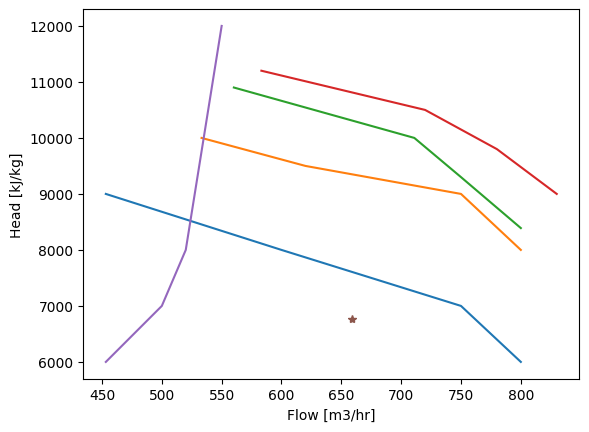

In [13]:
stream1.setFlowRate(0.8635, "MSm3/day")
stream1.run()
compressor2.setSpeed(1000)
compressor2.run()
import matplotlib.pyplot as plt
plt.plot(flow[0], head[0])
plt.plot(flow[1], head[1])
plt.plot(flow[2], head[2])
plt.plot(flow[3], head[3])
plt.plot(surgeFlow, surgeHead)
plt.plot(compressor2.getInStream().getFlowRate('m3/hr'), compressor2.getPolytropicHead(), marker='*')
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')

# Calculation of a gas compression train (two stage calculation)
In this example we calculate the pressure and power in a compression train of two compressors operating on the same shaft (same speed for both compressores). The calculations are further run for a series of inlet pressures, gas flow rates, compressor speeds. Resulting pressure levels and compressor powers are calculated. For details of the compressor code implementation see [this link to the Java code](https://github.com/equinor/neqsim/tree/master/src/main/java/neqsim/processSimulation/processEquipment/compressor).

In [14]:
gasFlowRate = 0.86#@param {type:"number"} # MSm3/day
compressorSpeed = 1500 #@param {type:"number"} # MSm3/day

temperature_inlet = 40.6 #@param {type:"number"} # temperature in C
pressure_inlet = 50.03 #@param {type:"number"} # pressure in bar

temperature_MP = 35.2 #@param {type:"number"} # temperature in C

fluid1 = fluid('srk')
fluid1.addComponent('methane', 83.099)
fluid1.addComponent('ethane', 6.925)
fluid1.addComponent('propane', 4.946)
fluid1.addComponent('i-butane', 1.484)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setMixingRule(2)

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1,70.0)
compressor_1.setUsePolytropicCalc(True)
coolerMP1 = heater(compressor_1.getOutStream())
coolerMP1.setOutTemperature(temperature_MP+273.15)
gasscrubber = separator(coolerMP1.getOutStream())
compressor_2 = compressor(gasscrubber.getGasOutStream(), 50.0)

speed = [1000.0, 2000.0, 3000.0, 4000.0]
flow = [[453.2, 600.0, 750.0, 800.0], [453.2, 600.0, 750.0, 800.0],[453.2, 600.0, 750.0, 800.0],[453.2, 600.0, 750.0, 800.0]]
head = [[ 10000.0, 9000.0, 8000.0, 7500.0], [10000.0, 9000.0, 8000.0, 7500.0 ], [10000.0, 9000.0, 8000.0, 7500.0], [ 10000.0, 9000.0, 8000.0, 7500.0]]
polyEff = [[ 90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.1],[90.0, 91.0, 89.0, 88.1]]
compressorChart(compressor2, curveConditions, speed, flow, head, polyEff)


compressorChart(compressor_1, curveConditions, speed, flow, head, polyEff)
compressor_1.setSpeed(2050);
compressor_1.setUsePolytropicCalc(True)

flow2 = [[253.2, 400.0, 650.0, 800.0], [253.2, 400.0, 650.0, 800.0],[253.2, 400.0, 650.0, 800.0],[253.2, 400.0, 650.0, 800.0]]
compressorChart(compressor_2, curveConditions, speed, flow2, head, polyEff)
compressor_2.setSpeed(2050);
compressor_2.setUsePolytropicCalc(True)


runProcess()

print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
print("compressor2 power ", compressor_2.getPower()/1e6, " MW")

print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")


compressor1 power  1.346363853477925  MW
compressor2 power  0.28367359349767224  MW
feed pressure  50.03  bara
1 stage pressure  149.79487079835394  bara
2 stage pressure  201.47835879794022  bara


In [15]:
inletPressure = [40.0, 50.0, 55.0]



# Using for loop
for pressure in inletPressure:
  stream1.getThermoSystem().setPressure(pressure)
  runProcess()
  print("feed pressure ", pressure)
  print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
  print("compressor2 power ", compressor_2.getPower()/1e6, " MW")
  print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
  print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
  print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")

stream1.getThermoSystem().setPressure(pressure_inlet)
inletFlow = [0.7, 0.8, 0.9, 1.0]
# Using for loop
for flow in inletFlow:
  stream1.getThermoSystem().setTotalFlowRate(flow, "MSm3/day")
  runProcess()
  print("flow ", flow)
  print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
  print("compressor2 power ", compressor_2.getPower()/1e6, " MW")
  print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
  print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
  print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")

stream1.getThermoSystem().setTotalFlowRate(gasFlowRate, "MSm3/day")
speedRuns = [1000, 1500, 2000]

# Using for loop
for speed in speedRuns:
  compressor_1.setSpeed(speed)
  compressor_2.setSpeed(speed)
  runProcess()
  print("speed ", speed)
  print("compressor1 power ", compressor_1.getPower()/1e6, " MW")
  print("compressor2 power ", compressor_2.getPower()/1e6, " MW")
  print("feed pressure ", stream1.getThermoSystem().getPressure("bara"), " bara")
  print("1 stage pressure ", compressor_1.getThermoSystem().getPressure("bara"), " bara")
  print("2 stage pressure ", compressor_2.getThermoSystem().getPressure("bara"), " bara")

feed pressure  40.0
compressor1 power  1.8739643310570908  MW
compressor2 power  0.21949286088259273  MW
feed pressure  40.0  bara
1 stage pressure  167.95200902382368  bara
2 stage pressure  211.28951906950803  bara
feed pressure  50.0
compressor1 power  1.3477084496663307  MW
compressor2 power  0.28348365859347024  MW
feed pressure  50.0  bara
1 stage pressure  149.84142322431154  bara
2 stage pressure  201.50187346428  bara
feed pressure  55.0
compressor1 power  1.139492978777697  MW
compressor2 power  0.31456782894949686  MW
feed pressure  55.0  bara
1 stage pressure  142.6709158368205  bara
2 stage pressure  197.9871188781852  bara
flow  0.7
compressor1 power  0.7756700671812945  MW
compressor2 power  0.2899245154210166  MW
feed pressure  50.03  bara
1 stage pressure  111.36390004764951  bara
2 stage pressure  159.95321187060648  bara
flow  0.8
compressor1 power  1.1186964760629958  MW
compressor2 power  0.2855647597214378  MW
feed pressure  50.03  bara
1 stage pressure  134.68871

# More examples of compressor calculations
Evaluation of alternative methods for compressor calculations

In [16]:
temperature_inlet = 40.6 #@param {type:"number"}
pressure_inlet = 7.93 #@param {type:"number"}

gasFlowRate = 2.86#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 83.099)
fluid1.addComponent('ethane', 6.925)
fluid1.addComponent('propane', 4.946)
fluid1.addComponent('i-butane', 1.484)
fluid1.addComponent('n-butane', 0.989)
fluid1.addComponent('i-pentane', 0.495)
fluid1.addComponent('n-pentane', 0.495)
fluid1.addComponent('n-hexane', 0.198)
fluid1.addComponent('n-heptane', 0.148)
fluid1.addComponent('n-octane', 0.099)
fluid1.addComponent('water', 0.983)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)
TPflash(fluid1)
fluid1.initProperties()
actFlowRate = fluid1.getFlowRate("m3/hr")
gasdensty = fluid1.getDensity("kg/m3")
kappa = fluid1.getPhase(0).getKappa()
MW = fluid1.getMolarMass()
enthalpy_inlet = fluid1.getEnthalpy('J/kg')
entropy_inlet = fluid1.getEntropy()
z_inlet = fluid1.getZ()
vol_inlet = fluid1.getVolume()
n=kappa;
print("kappa ", kappa)
print("actual flow rate ", actFlowRate, " m3/hr")

compressorspeed = 7992 # RPM

def polytropEfficiency(flow, speed):
        return 78.57

def polytropHead(flow, speed):
        return 15535.0

polytropEff = polytropEfficiency(actFlowRate, compressorspeed)
head_meter = polytropHead(actFlowRate, compressorspeed)

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropEff/100.0))
print("n ",n)
print("head_meter ", head_meter)
head_kjkg = head_meter/1000.0*9.81
pressureRatio = math.pow((head_kjkg*1000.0 +  (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW))/ (n/(n-1.0)*z_inlet*8.314*(temperature_inlet+273.15)/MW), n/(n-1.0))
print("pressure ratio ", pressureRatio)
pressure_outlet = pressure_inlet*pressureRatio
print("pressure out  ", pressure_outlet)

clearProcess()
stream1 = stream(fluid1)
compressor_1 = compressor(stream1, pressure_outlet)
compressor_1.setPolytropicEfficiency(polytropEff/100.0)
compressor_1.setUsePolytropicCalc(True)
runProcess()
print()
print("Calculations using polytropic efficiency: ", (polytropEff), '%')
print("compressor1 power ", compressor_1.getTotalWork()/1e6, " MW")
print("temperature out ", (compressor_1.getThermoSystem().getTemperature()-273.15))
print("pressure out ", (compressor_1.getThermoSystem().getPressure()))

kappa  1.2419141565372038
actual flow rate  16205.49354807249  m3/hr
n  1.3296471847434705
head_meter  15535.0
pressure ratio  2.897012868556815
pressure out   22.973312047655543

Calculations using polytropic efficiency:  78.57 %
compressor1 power  5.483253309822206  MW
temperature out  127.58341422739824
pressure out  22.97331204765553


In [17]:
temperature_inlet = 35.0 #@param {type:"number"}
pressure_inlet = 85.0 #@param {type:"number"}

pressure_Out = 150.0 #@param {type:"number"}
temperature_out = 100.0

gasFlowRate = 5.0#@param {type:"number"} # MSm3/day

polytropicEfficiency = 77.0 #@param {type:"number"} # compressor efficiency%

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, 'C')

TPflash(fluid1)
fluid1.initProperties()

kappa = fluid1.getPhase(0).getKappa()
print("kappa ", kappa)
MW = fluid1.getMolarMass()
density_inlet = fluid1.getDensity('kg/m3')
enthalpy_inlet = fluid1.getEnthalpy('J/kg')
entropy_inlet = fluid1.getEntropy()
z_inlet = fluid1.getZ()

n = 1.0/ (1.0 - (kappa-1.0)/kappa*1.0/(polytropicEfficiency/100.0))
print("polytropic exponent ", n)
power = n/(n-1.0)*(temperature_inlet+273.15)*z_inlet/(polytropicEfficiency/100.0)*(gasFlowRate*1.0e6/24.0/3600.0)*(101325.0/288.15)*(math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)-1.0)
estOutTemp = (temperature_inlet+273.15)*math.pow(pressure_Out/pressure_inlet, (n-1.0)/n)
print("power based in simple method ", power/1e6, "MW")
print("temperature out based on simple method ", (estOutTemp-273.15), " C")

fluid1.setPressure(pressure_Out, "bara")
PSflash(fluid1, entropy_inlet)
fluid1.initProperties()
enthalpy_isentr = fluid1.getEnthalpy('J/kg')
density_isentr = fluid1.getDensity('kg/m3')
Z_isentr = fluid1.getZ()

fluid1.setPressure(pressure_Out, 'bara')
fluid1.setTemperature(temperature_out, 'C')
TPflash(fluid1)
fluid1.initProperties()

density_outlet = fluid1.getDensity('kg/m3')
enthalpy_outlet = fluid1.getEnthalpy('J/kg')

k_s = math.log(pressure_Out/pressure_inlet)/math.log(density_outlet/density_inlet)

n = k_s/(k_s-1.0)

k_h = (enthalpy_outlet-enthalpy_isentr)/(100000.0 * n * (pressure_Out/density_isentr-pressure_inlet/density_inlet))

k_p = (1.0-math.log(density_outlet/density_inlet))/math.log(pressure_Out/pressure_inlet)
k_p

h_p = k_h*(temperature_inlet+273.15)*Z_isentr*8.314*(math.pow(pressure_Out/pressure_inlet,k_p)-1.0)/(MW*1000.0)/k_p

h_tot = h_p/(polytropicEfficiency/100.0)

E_p = h_tot*fluid1.getVolume('m3')/density_inlet

E_p

kappa  1.45715985758999
polytropic exponent  1.6876101898401001
power based in simple method  4.67005623452687 MW
temperature out based on simple method  115.23983254530901  C


1.1841780119115959

# Calcuation of compressor head, efficiency and power using the GERG-2008 EoS
In the following calculation we will use measured gas composition, flow rates and inlet and outlet temperatures to calculate compressor head, efficiency and power. The GERG-2008 EoS will be used internally in the compressor to calculate properties of the gas.

In [18]:
#Create fluid
from neqsim.thermo import fluid_df
import pandas as pd

naturalgas = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane"],
        'MolarComposition[-]':  [0.34, 0.84, 90.4, 5.199, 2.06, 0.36, 0.55, 0.14, 0.097, 0.014]
}

naturalgasdf = pd.DataFrame(naturalgas)
print("Natural Gas Fluid:\n")
print(naturalgasdf.head(30).to_string())
naturalgasFluid = fluid_df(naturalgasdf)

Natural Gas Fluid:

  ComponentName  MolarComposition[-]
0      nitrogen                0.340
1           CO2                0.840
2       methane               90.400
3        ethane                5.199
4       propane                2.060
5      i-butane                0.360
6      n-butane                0.550
7     i-pentane                0.140
8     n-pentane                0.097
9      n-hexane                0.014


In [19]:
from neqsim.process import stream,  compressor

gasCompostion = [0.34, 0.84, 90.4, 5.199, 2.06, 0.36, 0.55, 0.14, 0.097, 0.014]
gasFlowRate = 5.0

temperature_inlet = 35.0
pressure_inlet = 40.0

temperatureOut = 115.0
pressureOut = 90.0

naturalgasFluid.setMolarComposition(gasCompostion) # update composition
naturalgasFluid.setPressure(pressure_inlet, 'bara')
naturalgasFluid.setTemperature(temperature_inlet, 'C')
naturalgasFluid.setTotalFlowRate(gasFlowRate, "MSm3/day")

#Setting up a simple process (one stream and a compressor)
inputStream = stream(naturalgasFluid)
compressor_1 = compressor(inputStream)
compressor_1.setOutletPressure(pressureOut)
compressor_1.setOutTemperature(temperatureOut+273.15)
compressor_1.setUsePolytropicCalc(True)
compressor_1.setUseRigorousPolytropicMethod(False) #If True it will use advanced integrationm method (see section about regorous method based on EoS), if fasle it uses simplified method (described above)
compressor_1.setUseGERG2008(True) # If True GERG-2008 will be used internally in the calculation of the compressor (see implementation: https://github.com/equinor/neqsim/blob/master/src/main/java/neqsim/processSimulation/processEquipment/compressor/Compressor.java#L292)
inputStream.run()
compressor_1.run()

print("power ", compressor_1.getPower()/1e6, " MW")
print("polytropic efficiency ", compressor_1.getPolytropicEfficiency()*100, " %")
print("polytropic head ", compressor_1.getPolytropicHead("kJ/kg"), " kJ/kg")


deltaEnthalpy = compressor_1.getOutStream().getFluid().getEnthalpy("kJ/kg")-compressor_1.getInStream().getFluid().getEnthalpy("kJ/kg")
print('delta enthalpy', deltaEnthalpy, ' kJ/kg')

enthalpyOutGerg = compressor_1.getOutStream().getFluid().getPhase('gas').getProperties_GERG2008()[7]/compressor_1.getOutStream().getFluid().getPhase('gas').getMolarMass()/1000.0
enthalpyInGerg = compressor_1.getInStream().getFluid().getPhase('gas').getProperties_GERG2008()[7]/compressor_1.getInStream().getFluid().getPhase('gas').getMolarMass()/1000.0
deltaEnthalpyGERG = enthalpyOutGerg-enthalpyInGerg
print('delta enthalpy GERG2008 ', deltaEnthalpyGERG, ' kJ/kg')

power  7.298434428721965  MW
polytropic efficiency  73.13325871225011  %
polytropic head  120.14661401361928  kJ/kg
delta enthalpy 165.47276340600234  kJ/kg
delta enthalpy GERG2008  164.28450766339807  kJ/kg


## Calculation of density/property profile of compression path
In the following exmaple we calculate the compression path of a compressor

power  7.0098535524284085  MW
density stage 3  29.323233433930927  kg/m3
density stage 23  39.38550231651478  kg/m3


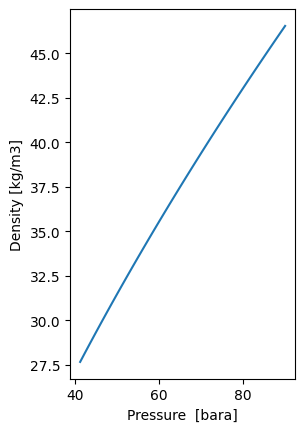

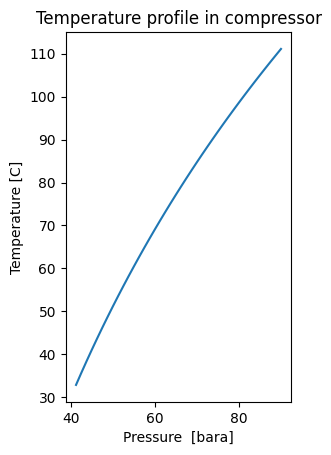

In [20]:
from neqsim.process import stream,  compressor, runProcess,clearProcess

gasFlowRate = 5.0
temperature_inlet = 30.0
pressure_inlet = 40.0
pressure_Out = 90.0

fluid1 = fluid('srk')
fluid1.addComponent('methane', 1.0)
fluid1.setPressure(pressure_inlet, 'bara')
fluid1.setTemperature(temperature_inlet, "C")
fluid1.setTotalFlowRate(gasFlowRate, "MSm3/day")

clearProcess()
inletStream  = stream(fluid1)
compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
compressor1.setPolytropicEfficiency(polytropicEfficiency/100.0)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicMethod('detailed')
compressor1.setNumberOfCompressorCalcSteps(40);
compressor1.getPropertyProfile().setActive(True);
runProcess()

print('power ', compressor1.getPower()/1e6, ' MW')
print('density stage 3 ',compressor1.getPropertyProfile().getFluid().get(3).getDensity("kg/m3"), ' kg/m3')
print('density stage 23 ', compressor1.getPropertyProfile().getFluid().get(23).getDensity("kg/m3"), ' kg/m3')


density = []
pressure = []
temperature = []

for i in range(40):
  density.append(compressor1.getPropertyProfile().getFluid().get(i).getDensity("kg/m3"))
  temperature.append(compressor1.getPropertyProfile().getFluid().get(i).getTemperature("C"))
  pressure.append(compressor1.getPropertyProfile().getFluid().get(i).getPressure("bara"))

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(pressure, density)
plt.xlabel("Pressure  [bara]")
plt.ylabel("Density [kg/m3]")
plt.show()

plt.subplot(1,2,2)
plt.plot(pressure, temperature)
plt.xlabel("Pressure  [bara]")
plt.ylabel("Temperature [C]")
plt.title("Temperature profile in compressor")
plt.show()

# Create lift curves for Eclipse based on compressor maps
In the following example we will generate lift curves to be used in Eclipse simulations based on compressor curves.

In [21]:
from neqsim.process import stream,  compressor, runProcess,clearProcess
from scipy.optimize import least_squares

gasFlowRate = 5.0
temperature_inlet = 30.0
pressure_inlet = 40.0
pressure_Out = 90.0

fluid1 = fluid('srk')
fluid1.addComponent('nitrogen', 1.0)
fluid1.addComponent('CO2', 1.0)
fluid1.addComponent('methane', 90.0)
fluid1.addComponent('ethane', 5.0)
fluid1.addComponent('propane', 3.0)


clearProcess()
inletStream  = stream(fluid1)
inletStream.setPressure(pressure_inlet, 'bara')
inletStream.setTemperature(temperature_inlet, "C")
inletStream.setFlowRate(gasFlowRate, "MSm3/day")

compressor1 = compressor(inletStream)
compressor1.setOutletPressure(pressure_Out)
runProcess()

print('flow rate ', compressor1.getInletStream().getFlowRate('m3/hr'), ' m3/hr')
print('inlet pressure ', compressor1.getInletStream().getPressure('bara'), ' bara')
print('outlet pressure ', compressor1.getOutletStream().getPressure('bara'), ' bara')
print('polytropic head ', compressor1.getPolytropicFluidHead(), ' kJ/kg')
print('head ', compressor1.getPolytropicHeadMeter(), ' meter')
print('power ', compressor1.getPower('MW'),  ' MW')

flow rate  5116.057516261762  m3/hr
inlet pressure  40.0  bara
outlet pressure  90.0  bara
polytropic head  116.31179074242331  kJ/kg
head  11856.451655700643  meter
power  5.119913309448702  MW


In [22]:
#input flow rate and out pressure, power

#predict input pressure

def calcinpres(inlet_pressure, power, outlet_pressure, flow, temperature_inlet):
  clearProcess()
  inletStream  = stream(fluid1)
  inletStream.setPressure(inlet_pressure, 'bara')
  inletStream.setTemperature(temperature_inlet, "C")
  inletStream.setFlowRate(flow, "MSm3/day")

  compressor1 = compressor(inletStream)
  compressor1.setOutletPressure(outlet_pressure)
  compressor1.setUsePolytropicCalc(True);
  compressor1.setPolytropicEfficiency(0.62);
  runProcess()
  return compressor1.getPower('MW')-power


inletpres = least_squares(calcinpres, 10.0, args=(5.0, 90.0, 5.0, 30.0));
print('inlet pressure ' ,inletpres.x[0], ' bara')

<ipython-input-22-9406e42606bd>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inletStream.setPressure(inlet_pressure, 'bara')


inlet pressure  54.363785066316304  bara


In [23]:
MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

speed = [1000.0, 2000.0, 3000.0, 4000.0]
flow = [[4503.2, 6000.0, 7500.0, 8000.0], [5330.2, 6200.0, 7500.0, 8000.0],[5600.2, 7110.0, 7500.0, 8000.0],[5830.2, 7200.0, 7800.0, 8300.0]]
head = [[ 9000.0*2, 8000.0*2, 7000.0*2, 6000.0*2], [10000.0*2, 9500.0*2, 9000.0*2, 8000.0*2 ], [10900.0*2, 10000.0*2, 9300.0*2, 8390.0*2], [ 11200.0*2, 10500.0*2, 9800.0*2, 9000.0*2]]
polyEff = [[ 90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.0 ], [90.0, 91.0, 89.0, 88.1],[90.0, 91.0, 89.0, 88.1]]

surgeFlow = [4530.2, 5000.0, 5200.0, 5500.0]
surgeHead = [6000.0, 7000.0, 8000.0, 12000.0]

inletStream  = stream(fluid1)
inletStream.setPressure(pressure_inlet, 'bara')
inletStream.setTemperature(temperature_inlet, "C")
inletStream.setFlowRate(7, "MSm3/day")
inletStream.run()

compressor1 = compressor(inletStream)
compressorChart(compressor1, curveConditions, speed, flow, head, polyEff)
compressor1.setUsePolytropicCalc(True)
compressor1.getAntiSurge().setSurgeControlFactor(1.05)
compressor1.setSpeed(4000)
compressor1.run()

print('flow rate ', compressor1.getInletStream().getFlowRate('m3/hr'), ' m3/hr')
print('inlet pressure ', compressor1.getInletStream().getPressure('bara'), ' bara')
print('outlet pressure ', compressor1.getOutletStream().getPressure('bara'), ' bara')
print('pressure ratio ', compressor1.getOutletStream().getPressure('bara')/compressor1.getInletStream().getPressure('bara'), ' -')
print('polytropic head ', compressor1.getPolytropicFluidHead(), ' kJ/kg')
print('polytropic efficiency ', compressor1.getPolytropicEfficiency()*100, ' %')
print('head ', compressor1.getPolytropicHead(), ' meter')
print('power ', compressor1.getPower('MW'),  ' MW')

flow rate  7162.480522766466  m3/hr
inlet pressure  40.0  bara
outlet pressure  69.29421614044891  bara
pressure ratio  1.7323554035112227  -
polytropic head  75.43230759857258  kJ/kg
polytropic efficiency  89.63112223080603  %
head  7689.327993799344  meter
power  5.186393456601157  MW


In [24]:
pressure_inlet = 40.0
temperature_inlet = 20.0
flow_rate = 7
pressure_outlet = 80.0

fluid1 = fluid('srk')
fluid1.addComponent('methane', 100.0)
fluid1.setMixingRule('classic')

inletStream  = stream(fluid1)
inletStream.setPressure(pressure_inlet, 'bara')
inletStream.setTemperature(temperature_inlet, "C")
inletStream.setFlowRate(flow_rate, "MSm3/day")
inletStream.run()

compressor1 = compressor(inletStream)
compressor1.setUsePolytropicCalc(True)
compressor1.setPolytropicEfficiency(0.62)
compressor1.setOutletPressure(pressure_outlet, 'bara')

compressor1.run()

print('Power ', compressor1.getPower('MW'),  'MW')

Power  10.050984110676257 MW


In [25]:
def calcpowerdev(inpers, power, rate, outpres):
  inletStream.setPressure(inpers, 'bara')
  inletStream.setFlowRate(rate, "MSm3/day")
  inletStream.run()
  compressor1.setOutletPressure(outpres, 'bara')
  compressor1.run()
  return compressor1.getPower('MW') - power


data = {'flow': [],  'in_pressure':[], 'out_pressure': [], 'pressure_ratio': [], 'power':[], 'feedflowAm3hr': [], 'polytropicfluidhead_kj_kg': []}

max_pressure_ratio = 3.5

for rate in [0.5, 2, 4, 6, 8, 10, 12, 14]:
  for THP in [10, 20, 40, 60, 80, 100, 120, 140, 180, 200]:
    for powerset in [5, 10, 15, 20]:
      inletpreure = least_squares(calcpowerdev, THP-5, args=(powerset, rate, THP), bounds=(THP/max_pressure_ratio, THP))
      data['flow'].append(rate)
      data['out_pressure'].append(THP)
      data['power'].append(round(compressor1.getPower('MW'),3))
      data['in_pressure'].append(round(inletpreure.x[0],5))
      data['pressure_ratio'].append(round(THP/inletpreure.x[0],3))
      data['feedflowAm3hr'].append(round(compressor1.getInletStream().getFlowRate('m3/hr'),3))
      data['polytropicfluidhead_kj_kg'].append(round(compressor1.getPolytropicFluidHead(),3))

from scipy.optimize import least_squares

df = pd.DataFrame(data)
df.to_csv('data - max pressure ratio 3_5.csv')

<ipython-input-25-305717230a02>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  inletStream.setPressure(inpers, 'bara')


# Compresssor minimum flow and antisurge line

In [26]:
from neqsim.process import stream,  compressor, runProcess,clearProcess,splitter,cooler,valve, mixer,recycle2

pressure_inlet = 55.0
temperature_inlet = 30.0

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 79.2)
fluid1.addComponent("ethane", 7.3)

gas_from_separator  = stream(fluid1)
gas_from_separator.setPressure(pressure_inlet, 'bara')
gas_from_separator.setTemperature(temperature_inlet, "C")
gas_from_separator.setFlowRate(7.0, "MSm3/day")
gas_from_separator.run()

recyclegasstream = gas_from_separator.clone()
recyclegasstream.setFlowRate(1.0, "MSm3/day")
recyclegasstream.run()

gasmixer = mixer("gas mixer")
gasmixer.addStream(gas_from_separator)
gasmixer.addStream(recyclegasstream)
gasmixer.run()

gascompressor = compressor("gas compressor")
gascompressor.setInletStream(gasmixer.getOutStream())
gascompressor.setOutletPressure(90.0, "bara")
gascompressor.run()

printFrame(gascompressor.getOutStream().getFluid())

gascooler = cooler("gas cooler")
gascooler.setInletStream(gascompressor.getOutStream())
gascooler.setOutTemperature(54.0, 'C')
gascooler.setOutPressure(89.0, 'bara')
gascooler.run();



gassep = separator("gas separator")
gassep.setInletStream(gascooler.getOutStream())
gassep.run()

gassplitter = splitter("gas splitter")
gassplitter.setInletStream(gassep.getOutStream())
gassplitter.setSplitFlows(-1, 0.5)
gassplitter.run()


antisurgevalve = valve("antisurge valve")
antisurgevalve.setInletStream(gassplitter.getOutStream())
antisurgevalve.run()

recycl = recycle2(antisurgevalve.getOutStream())
recycl.setOutletStream(recyclegasstream)
recycl.run()










| 0                    | 1          | 2                 | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:------------------|:----|:----|:----|:----------------|
|                      | total      | GAS               |     |     |     |                 |
| nitrogen             | 1.11732E-2 | 1.11732E-2        |     |     |     | [mole fraction] |
| CO2                  | 2.23464E-2 | 2.23464E-2        |     |     |     | [mole fraction] |
| methane              | 8.84916E-1 | 8.84916E-1        |     |     |     | [mole fraction] |
| ethane               | 8.15642E-2 | 8.15642E-2        |     |     |     | [mole fraction] |
|                      |            |                   |     |     |     |                 |
| Density              |            | 6.22751E1         |     |     |     | kg/m3           |
| Phase Fraction       |            | 1E0               |     |     |     | [mole fraction] |
| Molar Mass           | 1.79458E-2 | 1.79458E-2        |   

AttributeError: 'neqsim.processSimulation.processEquipment.separato' object has no attribute 'getOutStream'

In [88]:
from neqsim.process import stream, splitter, compressor, splitter, cooler, valve, mixer, recycle2, calculator
from neqsim import jNeqSim

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 1.0)
fluid1.addComponent("CO2", 2.0)
fluid1.addComponent("methane", 79.2)
fluid1.addComponent("ethane", 7.3)
fluid1.setMixingRule("classic")

gas_from_separator = stream(fluid1,"feed stream")
gas_from_separator.setPressure(55.0, "bara")
gas_from_separator.setTemperature(30.0, "C")
gas_from_separator.setFlowRate(7.0, "MSm3/day")

recyclegasstream = stream(gas_from_separator.clone())
recyclegasstream.setFlowRate(1.2, "MSm3/day")

gasmixer = mixer("gas mixer")
gasmixer.addStream(gas_from_separator)
gasmixer.addStream(recyclegasstream)

gascompressor = compressor("gas compressor")
gascompressor.setInletStream(gasmixer.getOutletStream())
gascompressor.setOutletPressure(90.0, "bara")

gascooler = cooler("gas cooler");
gascooler.setInletStream(gascompressor.getOutletStream())
gascooler.setOutTemperature(30.0, "C")

gassep = separator("gas separator")
gassep.setInletStream(gascooler.getOutletStream())

gassplitter = splitter("gas splitter")
gassplitter.setInletStream(gassep.getGasOutStream())
gassplitter.setFlowRates([7.0, 1.2], "MSm3/day")

antisurgevalve = valve(gassplitter.getSplitStream(1))
antisurgevalve.setName("anita surge valve")
antisurgevalve.setOutletPressure(55.0, "bara")

recycl = jNeqSim.processSimulation.processEquipment.util.Recycle("rec")
recycl.addStream(antisurgevalve.getOutletStream())
recycl.setOutletStream(recyclegasstream)
recycl.setFlowAccuracy(1e-15)

operations = jNeqSim.processSimulation.processSystem.ProcessSystem();
operations.add(gas_from_separator);
operations.add(recyclegasstream);
operations.add(gasmixer);
operations.add(gascompressor);
operations.add(gascooler);
operations.add(gassep);
operations.add(gassplitter);
operations.add(antisurgevalve);
operations.add(recycl);

operations.run();

exportflowrate = gassplitter.getSplitStream(0).getFlowRate("MSm3/day")
surgeflowrate = gassplitter.getSplitStream(1).getFlowRate("MSm3/day")
outpressure = gascompressor.getOutletPressure()
flow = gascompressor.getInletStream().getFlowRate("m3/hr")
polytropichead = gascompressor.getPolytropicFluidHead()
print(exportflowrate, surgeflowrate, outpressure, polytropichead, flow)

compchartgenerator = jNeqSim.processSimulation.processEquipment.compressor.CompressorChartGenerator(gascompressor)
gascompressor.setCompressorChart(compchartgenerator.generateCompressorChart("mid range"))
gascompressor.getCompressorChart().setUseCompressorChart(False)

antisurgeCalculator = jNeqSim.processSimulation.processEquipment.util.Calculator("anti surge calculator")
antisurgeCalculator.addInputVariable(gascompressor)
antisurgeCalculator.setOutputVariable(gassplitter)

operations.add(antisurgeCalculator)

operations.run()

exportflowrate = gassplitter.getSplitStream(0).getFlowRate("MSm3/day")
surgeflowrate = gassplitter.getSplitStream(1).getFlowRate("MSm3/day")
surgeflow = gascompressor.getCompressorChart().getSurgeCurve().getSurgeFlow(gascompressor.getPolytropicFluidHead())
flow = gascompressor.getInletStream().getFlowRate("m3/hr")
outpressure = gascompressor.getOutletPressure()
polytropichead = gascompressor.getPolytropicFluidHead()
print(exportflowrate, surgeflowrate, outpressure, polytropichead, surgeflow, flow)

gas_from_separator.setFlowRate(2.0, "MSm3/day")
operations.run()

exportflowrate = gassplitter.getSplitStream(0).getFlowRate("MSm3/day")
surgeflowrate = gassplitter.getSplitStream(1).getFlowRate("MSm3/day")
surgeflow = gascompressor.getCompressorChart().getSurgeCurve().getSurgeFlow(gascompressor.getPolytropicFluidHead())
flow = gascompressor.getInletStream().getFlowRate("m3/hr")
outpressure = gascompressor.getOutletPressure()
polytropichead = gascompressor.getPolytropicFluidHead()
print(exportflowrate, surgeflowrate, outpressure, polytropichead, surgeflow, flow)

gas_from_separator.setFlowRate(6.0, "MSm3/day")
operations.run()

exportflowrate = gassplitter.getSplitStream(0).getFlowRate("MSm3/day")
surgeflowrate = gassplitter.getSplitStream(1).getFlowRate("MSm3/day")
surgeflow = gascompressor.getCompressorChart().getSurgeCurve().getSurgeFlow(gascompressor.getPolytropicFluidHead())
flow = gascompressor.getInletStream().getFlowRate("m3/hr")
outpressure = gascompressor.getOutletPressure()
polytropichead = gascompressor.getPolytropicFluidHead()
print(exportflowrate, surgeflowrate, outpressure, polytropichead, surgeflow, flow)

7.0000000000000036 1.2 90.0 66.08274705429486 5895.488914185134
7.000000000000001 1.000000000814321e-06 90.0 66.77236527113031 4559.988182020886 5087.030528388716
2.000001045210187 1.5949095554827606 90.0 64.67281877994928 4543.2676557864315 2527.6122467387636
5.737268428675114 0.2627325713248874 90.0 66.77236515920062 4559.988181132691 4360.311977738711


In [ ]:




    operations.run();
    assertEquals(6.9999999, gassplitter.getSplitStream(0).getFlowRate("MSm3/day"), 1e-4);
    assertEquals(1e-6, gassplitter.getSplitStream(1).getFlowRate("MSm3/day"), 1e-4);
    assertEquals(4646.77601821, gascompressor.getCompressorChart().getSurgeCurve()
        .getSurgeFlow(gascompressor.getPolytropicFluidHead()), 1e-4);
    assertEquals(90.0, gascompressor.getOutletPressure(), 1e-4);

    gas_from_separator.setFlowRate(2.0, "MSm3/day");
    operations.run();
    assertEquals(1.58988554, gassplitter.getSplitStream(1).getFlowRate("MSm3/day"), 1e-2);
    assertEquals(1.99847869184, gassplitter.getSplitStream(0).getFlowRate("MSm3/day"), 1e-4);
    assertEquals(4632.1489149, gascompressor.getCompressorChart().getSurgeCurve()
        .getSurgeFlow(gascompressor.getPolytropicFluidHead()), 1e-4);
    assertEquals(90.0, gascompressor.getOutletPressure(), 1e-4);

    gas_from_separator.setFlowRate(8.0, "MSm3/day");
    operations.run();
    assertEquals(1.0000000000014376E-6, gassplitter.getSplitStream(1).getFlowRate("MSm3/day"),
        1e-4);
    assertEquals(8.000000000000004, gassplitter.getSplitStream(0).getFlowRate("MSm3/day"), 1e-4);
    assertEquals(4646.77601880, gascompressor.getCompressorChart().getSurgeCurve()
        .getSurgeFlow(gascompressor.getPolytropicFluidHead()), 1e-4);
    assertEquals(90.0, gascompressor.getOutletPressure(), 1e-4);

    double[] flows = new double[] {7044, 7560, 7760};
    double[] head = new double[] {74, 80, 90};
    SurgeCurve surg = new SurgeCurve(flows, head);
    gascompressor.getCompressorChart().setSurgeCurve(surg);
    operations.run();
    assertEquals(6753.1900, gascompressor.getCompressorChart().getSurgeCurve()
        .getSurgeFlow(gascompressor.getPolytropicFluidHead()), 1e-2);
    assertEquals(5998.55269, gascompressor.getInletStream().getFlowRate("m3/hr"), 1e-4);
    assertEquals(0.9071841061, gassplitter.getSplitStream(1).getFlowRate("MSm3/day"), 1e-4);

In [ ]:



compressor1 = compressor(inletStream)
compressorChart(compressor1, curveConditions, speed, flow, head, polyEff)
compressor1.setUsePolytropicCalc(True)
compressor1.getAntiSurge().setSurgeControlFactor(1.05)
compressor1.setSpeed(4000)
compressor1.run()

compressorcooler = cooler(compressor1.getOutStream())
compressorcooler.setName("1st stage cooler")
compressorcooler.setOutTemperature(30.0, 'C')

scrub = separator('gas scrubb')

gassplit = splitter('gas spliktter')
gassplit.setInletStream(scrub.getOutStream())
gassplit.setSplitFlows(-1, 0.5)

valvejt = valve(gassplit.getOutStream())




print('flow rate ', compressor1.getInletStream().getFlowRate('m3/hr'), ' m3/hr')
print('inlet pressure ', compressor1.getInletStream().getPressure('bara'), ' bara')
print('outlet pressure ', compressor1.getOutletStream().getPressure('bara'), ' bara')
print('pressure ratio ', compressor1.getOutletStream().getPressure('bara')/compressor1.getInletStream().getPressure('bara'), ' -')
print('polytropic head ', compressor1.getPolytropicFluidHead(), ' kJ/kg')
print('polytropic efficiency ', compressor1.getPolytropicEfficiency()*100, ' %')
print('head ', compressor1.getPolytropicHead(), ' meter')